In [1]:
# Run this code to unzip the Skin Diseases Data into a "dataset" folder
import zipfile as zf
files = zf.ZipFile("archive.zip", 'r')
files.extractall('dataset')
files.close()

In [1]:
# Useful Imports

# Torch Imports
import torch 
import torch.nn as nn
import torch.utils.data as data

# Torchvision Imports
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models

# Utility Imports
import matplotlib.pyplot as plt
import numpy as np

# Metric and Matrix Imports
import seaborn as sns
from sklearn.metrics import precision_score, recall_score, confusion_matrix, f1_score, accuracy_score

# Bayesian Optimization Imports
import GPyOpt

In [3]:
# Converts every image to 256x256 dimension, randomly change images for generalization,
# into a tensor, normalize pixel values
train_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=15),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Converts every image to 256x256 dimension and into a Tensor
val_test_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Loads each subset directory from your "dataset" folder
train_dataset = datasets.ImageFolder(root='dataset/Train', transform=train_transform)
test_dataset = datasets.ImageFolder(root='dataset/Test', transform=val_test_transform)
val_dataset = datasets.ImageFolder(root='dataset/Val', transform=val_test_transform)

# Hyper Parameters for dataset organization and processing
batch_size = 25
num_workers = 3
# Dataloader for each subset which will batch, shuffle, and parallel load the data
train_dataloader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
test_dataloader = data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
val_dataloader = data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

In [4]:
# Total images in each subset
print('Train data: ', len(train_dataset))
print('Test data: ', len(test_dataset))
print('Valid data: ', len(val_dataset))

Train data:  1198
Test data:  389
Valid data:  250


In [5]:
# distribution of classes across datasets:
# https://discuss.pytorch.org/t/how-to-see-distribution-of-labels-in-dataset/158379
from collections import Counter
train_labels = dict(Counter(train_dataset.targets))
val_labels = dict(Counter(val_dataset.targets))
test_labels = dict(Counter(test_dataset.targets))

print(train_labels.values())
print(val_labels.values())
print(test_labels.values())

diseases = ['Herpes', 'Melanoma', 'Monkeypox', 'Sarampion', 'Varicela']

dict_values([250, 300, 248, 200, 200])
dict_values([50, 50, 50, 50, 50])
dict_values([86, 100, 88, 43, 72])


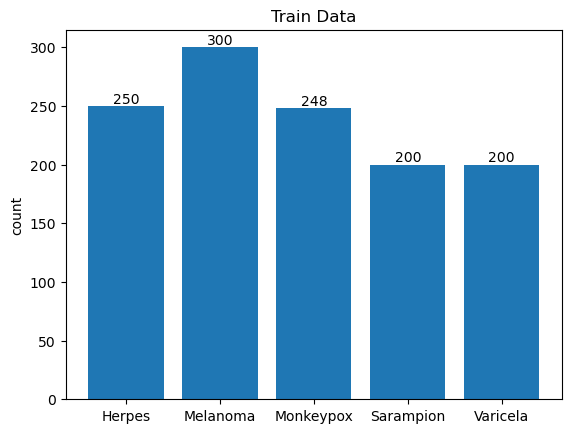

In [6]:
fig_train, ax_train = plt.subplots()
p_train = ax_train.bar(diseases, train_labels.values())
ax_train.bar_label(p_train)
ax_train.set_ylabel('count')
ax_train.set_title('Train Data')
plt.show()

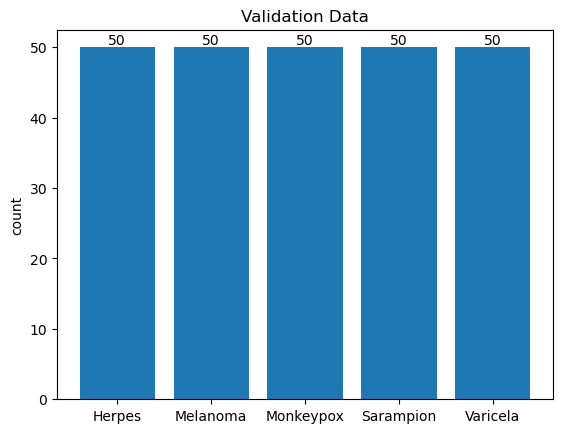

In [7]:
fig_val, ax_val = plt.subplots()
p_val = ax_val.bar(diseases, val_labels.values())
ax_val.bar_label(p_val)
ax_val.set_ylabel('count')
ax_val.set_title('Validation Data')
plt.show()

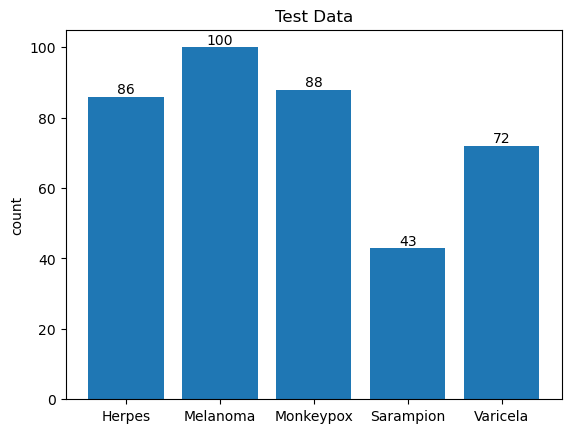

In [8]:
fig_test, ax_test = plt.subplots()
p_test = ax_test.bar(diseases, test_labels.values())
ax_test.bar_label(p_test)
ax_test.set_ylabel('count')
ax_test.set_title('Test Data')
plt.show()

torch.Size([3, 128, 128])
tensor(0)
torch.Size([25, 3, 128, 128])
torch.Size([25])


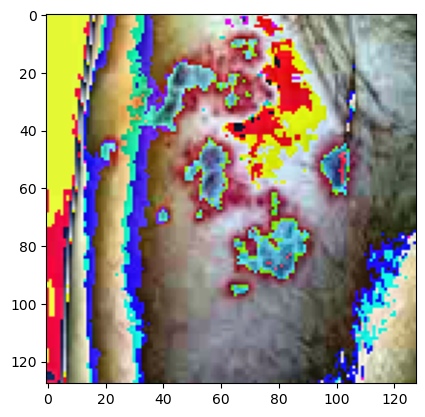

In [9]:
# Check a batch of data
images, labels = next(iter(train_dataloader))

print(images[0].size()) # Number of Colors (RGB=3), Height=256, Width=256
print(labels[0]) # Herpes=0, Melanoma=1, Monkeypox=2, Sarampion=3, Varicela=4
print(images.shape)
print(labels.shape)

# Will show the image sampled
image = transforms.ToPILImage()(images[0])
plt.imshow(image)
plt.show()

In [10]:
# Calculates output layer size, convenient when making multiple hidden layers
def output_size(in_channels, kernel_size, padding, stride, pool):
    return np.floor((((in_channels - kernel_size + (2 * padding)) / stride) + 1) / pool)

# Test Run of output_size
output_shape = output_size(128, 3, 0, 1, 2)
print(output_shape)

63.0


In [11]:
# Custom CNN Model

class CustomCNN(nn.Module):
    def __init__(self, dropout, kernel, channels):
        super(CustomCNN, self).__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, channels, kernel_size=kernel, stride=1, padding=0), 
            nn.BatchNorm2d(channels),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.MaxPool2d(kernel_size=2, stride=2)) 

        output_shape = output_size(128, kernel, 0, 1, 2)
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(channels, channels*2, kernel_size=kernel, stride=1, padding=0), 
            nn.BatchNorm2d(channels*2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.MaxPool2d(kernel_size=2, stride=2)) 

        output_shape = output_size(output_shape, kernel, 0, 1, 2)
        
        self.conv3 = nn.Sequential(
            nn.Conv2d(channels*2, channels*4, kernel_size=kernel, stride=1, padding=0), 
            nn.BatchNorm2d(channels*4),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.MaxPool2d(kernel_size=2, stride=2)) 

        output_shape = output_size(output_shape, kernel, 0, 1, 2)
        
        self.conv4 = nn.Sequential(
            nn.Conv2d(channels*4, channels*2, kernel_size=kernel, stride=1, padding=0), 
            nn.BatchNorm2d(channels*2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.MaxPool2d(kernel_size=2, stride=2))

        output_shape = output_size(output_shape, kernel, 0, 1, 2)

        self.conv5 = nn.Sequential(
            nn.Conv2d(channels*2, channels, kernel_size=kernel, stride=1, padding=0), 
            nn.BatchNorm2d(channels),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.MaxPool2d(kernel_size=2, stride=2))

        output_shape = output_size(output_shape, kernel, 0, 1, 2)
        
        self.flatten = nn.Flatten()
        
        self.fc1 = nn.Sequential(
            nn.Linear(channels*int(output_shape)*int(output_shape), channels*2),
            nn.ReLU())

        self.fc2 = nn.Sequential(
            nn.Linear(channels*2, channels),
            nn.ReLU())
        
        self.fc3 = nn.Linear(channels, 5)

    def forward(self, out):
        out = self.conv1(out)
        out = self.conv2(out)
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.conv5(out)
        out = self.flatten(out)
        out = self.fc1(out)
        out = self.fc2(out)
        out = self.fc3(out)
        
        return out

In [8]:
# Allows model to run on GPU if it is present
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [13]:
# Test run, should output torch.Size([batch_size, classes])
custom_cnn = CustomCNN(dropout=0.3, kernel=3, channels=32).to(device)
output = custom_cnn(images.to(device))
print(output.size())

torch.Size([25, 5])


In [2]:
# Define a train_model function
def train_model(model, criterion, optimizer, epochs):
    total_step = len(train_dataloader)
    
    for epoch in range(epochs):
        loss_per_epoch = 0
        for i, (images, labels) in enumerate(train_dataloader):
            images = images.to(device)
            labels = labels.to(device)
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            loss_per_epoch += loss.item()
            #print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                    #.format(epoch+1, epochs, i+1, total_step, loss.item()))
        print(f"Epoch: {epoch+1}, {loss_per_epoch/total_step}")

In [15]:
# Declare Custom CNN Model
custom_cnn = CustomCNN(dropout=0.1, kernel=3, channels=32).to(device)

# Set Hyper Parameters
epochs = 50
learning_rate = 0.0001

# Declare Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(custom_cnn.parameters(), lr = learning_rate)

In [16]:
# Train Custom CNN Model
train_model(custom_cnn, criterion, optimizer, epochs)

Epoch: 1, 1.5360856453577678
Epoch: 2, 1.3992215022444725
Epoch: 3, 1.2788121476769447
Epoch: 4, 1.185199573636055
Epoch: 5, 1.092029083520174
Epoch: 6, 1.0280181504786015
Epoch: 7, 0.9583469368517399
Epoch: 8, 0.9080223763982455
Epoch: 9, 0.8606226295232773
Epoch: 10, 0.8040196436146895
Epoch: 11, 0.7709810584783554
Epoch: 12, 0.7356949485838413
Epoch: 13, 0.710061514750123
Epoch: 14, 0.6783936135470867
Epoch: 15, 0.6592731593797604
Epoch: 16, 0.62844351430734
Epoch: 17, 0.6143576676646868
Epoch: 18, 0.5622767545282841
Epoch: 19, 0.5451500757286946
Epoch: 20, 0.5482096932828426
Epoch: 21, 0.5110504515469074
Epoch: 22, 0.4930246341973543
Epoch: 23, 0.4722013510763645
Epoch: 24, 0.4563008003557722
Epoch: 25, 0.4397513335570693
Epoch: 26, 0.4408169922729333
Epoch: 27, 0.4008515203992526
Epoch: 28, 0.41515213375290233
Epoch: 29, 0.3942177888626854
Epoch: 30, 0.37453668005764484
Epoch: 31, 0.34631295191744965
Epoch: 32, 0.33865587692707777
Epoch: 33, 0.3077650365109245
Epoch: 34, 0.3310438

In [3]:
# Define a calculate_accuracy function
def calculate_accuracy(model, dataloader, device):
    model.eval()
    
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)
    
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
    
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    print(f'Accuracy: {accuracy}%')

In [4]:
# Produces a confusion matrix, and metrics including Precision, Recall, and F1 Score
def confusion_matrix_and_metrics(model, dataloader, device):
    model.eval()
    
    y_true = []
    y_pred = []

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        cm, 
        annot=True, 
        fmt="d", 
        cmap="Blues", 
        xticklabels=dataloader.dataset.classes, 
        yticklabels=dataloader.dataset.classes)
    
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()
    
    print("Precision of the MLP :\t"+str(precision_score(y_true, y_pred, average="macro")))
    print("Recall of the MLP    :\t"+str(recall_score(y_true, y_pred, average="macro")))
    print("F1 Score of the Model :\t"+str(f1_score(y_true, y_pred, average="macro")))

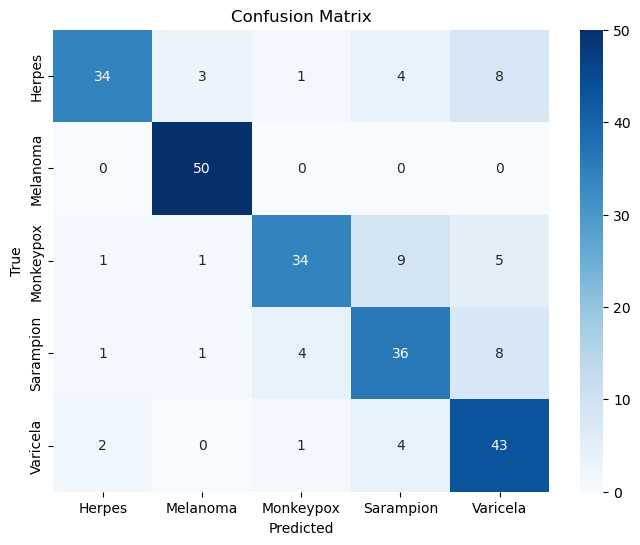

Precision of the MLP :	0.800989606843008
Recall of the MLP    :	0.788
F1 Score of the Model :	0.7868157743579307
Accuracy: 78.8%


In [19]:
# Calculate Custom CNN Accuracy, Matrix, and Metrics
confusion_matrix_and_metrics(custom_cnn, val_dataloader, device)
calculate_accuracy(custom_cnn, val_dataloader, device)

In [94]:
# Implementation of Bayesian Optimization to improve Hyper Parameters

# Representation of how our model is changed
def objective(params):
    
    learning_rate = params[0][0]
    batch_size = int(params[0][1])
    dropout = params[0][2]
    kernel = int(params[0][3])
    channels = int(params[0][4])
    
    custom_cnn = CustomCNN(dropout, kernel, channels).to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(custom_cnn.parameters(), lr = learning_rate)

    train_dataloader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=3)
    val_dataloader = data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=3)

    custom_cnn.train()
    for epoch in range(20):
        for images, labels in train_dataloader:
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = custom_cnn(images)
            loss = criterion(outputs, labels)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    custom_cnn.eval()
    y_true = []
    y_pred = []
    
    with torch.no_grad():
        for images, labels in val_dataloader:
            images = images.to(device)
            labels = labels.to(device)
    
            outputs = custom_cnn(images)
            _, predicted = torch.max(outputs, 1)
    
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
    
    accuracy = accuracy_score(y_true, y_pred)
    print(-accuracy)
    return -accuracy

In [95]:
# Range of tested values in Bayesian Optimization
domain = [
    {"name": "learning_rate", "type": "continuous", "domain": (1e-5, 1e-2)},
    {"name": "batch_size", "type": "discrete", "domain": [25, 50, 100, 200]},
    {"name": "dropout", "type": "continuous", "domain": (0.1, 0.7)},
    {"name": "kernel", "type": "discrete", "domain": [3, 5, 7]},
    {"name": "channels", "type": "discrete", "domain": [8, 16, 32, 64, 128]}
]

# Run Bayesian Optimization
opt = GPyOpt.methods.BayesianOptimization(f=objective, domain=domain)
opt.run_optimization(max_iter=10)

0.2
0.388
0.316
0.208
0.376
0.416
0.404
0.288
0.604
0.512


In [96]:
# Print Results
best_params = opt.X[np.argmin(opt.Y)]
param_names = ["Learning Rate", "Batch Size", "Dropout", "Kernel Size", "Channels"]

print("Best Hyper Parameters: ")
for param_name, best_param in zip(param_names, best_params):
    if param_name == "Learning Rate" or param_name == "Dropout":
        print(f'{param_name}: {float(best_param)}')
    else:
        print(f'{param_name}: {int(best_param)}')
print(f'Loss: {-np.min(opt.Y)}')

Best Hyper Parameters: 
Learning Rate: 1e-05
Batch Size: 25
Dropout: 0.1
Kernel Size: 3
Channels: 32
Loss: 0.604


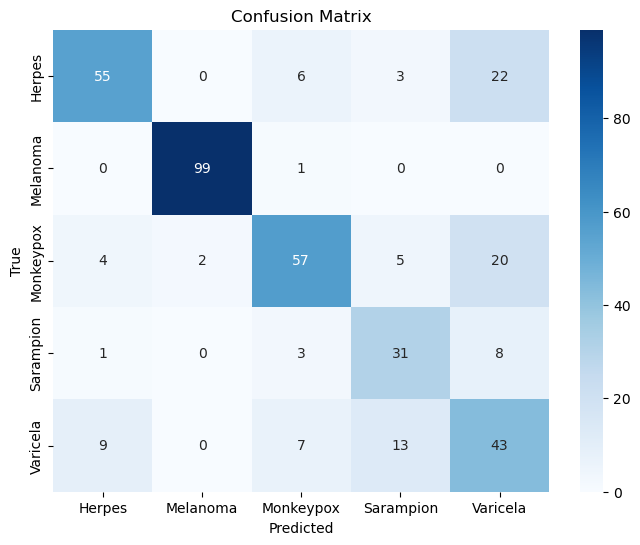

Precision of the MLP :	0.7212178353798617
Recall of the MLP    :	0.719082922245713
F1 Score of the Model :	0.7144598900167407
Accuracy: 73.26478149100257%


In [20]:
# Test Custom CNN Accuracy, Matrix, and Metrics
confusion_matrix_and_metrics(custom_cnn, test_dataloader, device)
calculate_accuracy(custom_cnn, test_dataloader, device)

In [21]:
# Data organization for ResNet Models
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Loads each subset directory from your "dataset" folder
train_dataset = datasets.ImageFolder(root='dataset/Train', transform=transform)
test_dataset = datasets.ImageFolder(root='dataset/Test', transform=transform)
val_dataset = datasets.ImageFolder(root='dataset/Val', transform=transform)

# Hyper Parameters for dataset organization and processing
batch_size = 25
num_workers = 3
# Dataloader for each subset which will batch, shuffle, and parallel load the data
train_dataloader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
test_dataloader = data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
val_dataloader = data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

In [22]:
# Declare ResNet50 Model
#weights=torchvision.models.ResNet50_Weights.DEFAULT
resnet_50 = torchvision.models.resnet50(pretrained=True)

for param in resnet_50.parameters():
    param.requires_grad = False
        
resnet_50.fc = nn.Linear(resnet_50.fc.in_features, 5)
resnet_50 = resnet_50.to(device)

In [23]:
epochs = 50
learning_rate = 0.0001

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet_50.parameters(), lr = learning_rate)

In [24]:
train_model(resnet_50, criterion, optimizer, epochs)

Epoch: 1, 1.4759794895847638
Epoch: 2, 1.2561026414235432
Epoch: 3, 1.109113768984874
Epoch: 4, 0.9999419463177522
Epoch: 5, 0.9176950653394064
Epoch: 6, 0.864570926874876
Epoch: 7, 0.8062255171438059
Epoch: 8, 0.7793282369772593
Epoch: 9, 0.7351978508134683
Epoch: 10, 0.7108428633461396
Epoch: 11, 0.6810735054314137
Epoch: 12, 0.6624477822333574
Epoch: 13, 0.6502353108177582
Epoch: 14, 0.6241559243450562
Epoch: 15, 0.6124755752583345
Epoch: 16, 0.6052146373937527
Epoch: 17, 0.5837534684687853
Epoch: 18, 0.5639183595776558
Epoch: 19, 0.568071011453867
Epoch: 20, 0.5555130715171496
Epoch: 21, 0.5391060852756103
Epoch: 22, 0.5195994631697735
Epoch: 23, 0.5261760937670866
Epoch: 24, 0.5077656358480453
Epoch: 25, 0.5090879881754518
Epoch: 26, 0.5006280777355036
Epoch: 27, 0.49869956634938717
Epoch: 28, 0.4872417102257411
Epoch: 29, 0.4758760780096054
Epoch: 30, 0.4643389377743006
Epoch: 31, 0.47344232195367414
Epoch: 32, 0.46209118360032636
Epoch: 33, 0.45669274652997655
Epoch: 34, 0.45203

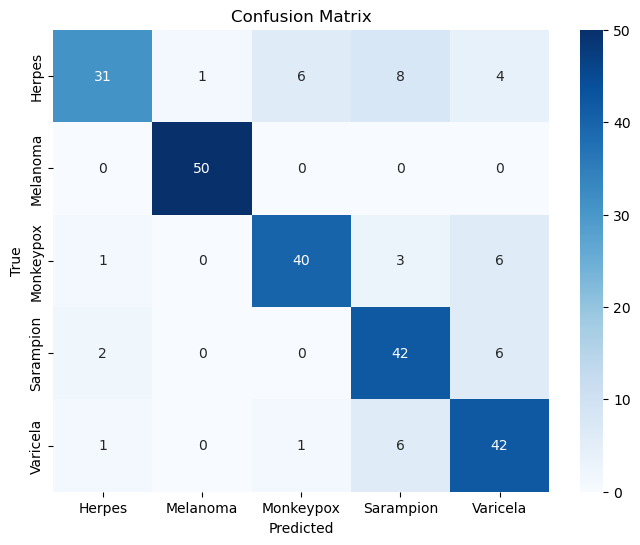

Precision of the MLP :	0.8306345220356818
Recall of the MLP    :	0.82
F1 Score of the Model :	0.8185346044521499
Accuracy: 82.0%


In [25]:
# Caculate Validation Accuracy, Matrix, and Metrics
confusion_matrix_and_metrics(resnet_50, val_dataloader, device)
calculate_accuracy(resnet_50, val_dataloader, device)

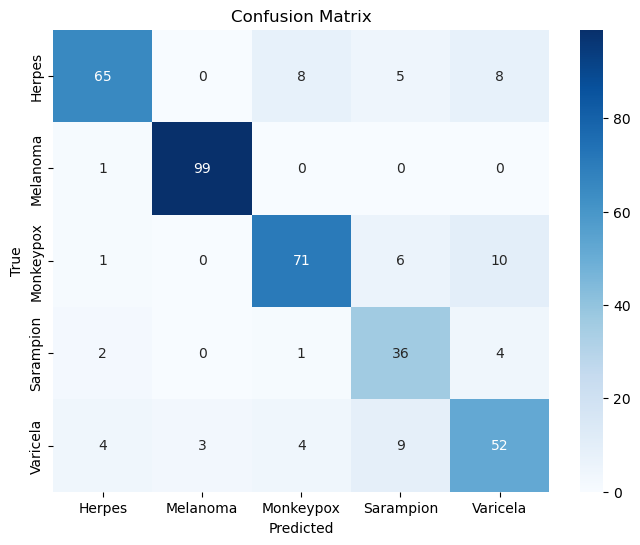

Precision of the MLP :	0.8103594269992337
Recall of the MLP    :	0.8224127319708716
F1 Score of the Model :	0.8125981944879829
Accuracy: 83.03341902313625%


In [26]:
# Caculate Test Accuracy, Matrix, and Metrics
confusion_matrix_and_metrics(resnet_50, test_dataloader, device)
calculate_accuracy(resnet_50, test_dataloader, device)

In [ ]:
# from torch.utils.data.sampler import SubsetRandomSampler
# # Data organization for AlexNet model
# # https://www.digitalocean.com/community/tutorials/alexnet-pytorch
# def get_train_valid_loader(batch_size=25, augment=False, random_seed=1, shuffle=True, num_workers=3):
#     normalize = transforms.Normalize(
#         mean=[0.485, 0.456, 0.406],
#         std=[0.229, 0.224, 0.225],
#     )

#     # define transforms
#     valid_transform = transforms.Compose([
#             transforms.Resize((227,227)),
#             transforms.ToTensor(),
#             normalize,
#     ])
#     if augment:
#         train_transform = transforms.Compose([
#             transforms.RandomCrop(32, padding=4),
#             transforms.RandomHorizontalFlip(),
#             transforms.ToTensor(),
#             normalize,
#         ])
#     else:
#         train_transform = transforms.Compose([
#             transforms.Resize((227,227)),
#             transforms.ToTensor(),
#             normalize,
#         ])

#     # load the dataset
#     train_dataset = datasets.ImageFolder(root='dataset/Train', transform=train_transform)
#     valid_dataset = datasets.ImageFolder(root='dataset/Test', transform=valid_transform)

#     num_train = len(train_dataset)
#     indices = list(range(num_train))
#     if shuffle:
#         np.random.seed(random_seed)
#         np.random.shuffle(indices)
#     train_sampler = SubsetRandomSampler(indices)

#     train_loader = data.DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler, num_workers=num_workers)
#     valid_loader = data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

#     return (train_loader, valid_loader)


# def get_test_loader(batch_size=25, num_workers=3):
#     normalize = transforms.Normalize(
#         mean=[0.485, 0.456, 0.406],
#         std=[0.229, 0.224, 0.225],
#     )

#     # define transform
#     transform = transforms.Compose([
#         transforms.Resize((227,227)),
#         transforms.ToTensor(),
#         normalize,
#     ])

#     test_dataset = datasets.ImageFolder(root='dataset/Test', transform=transform)

#     test_dataloader = data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

#     return test_dataloader

In [ ]:
# train_loader, valid_loader = get_train_valid_loader()
# test_loader = get_test_loader()

In [82]:
# Data organization for AlexNet model
# do we need consistent shuffle across different models? (will it affect model evaluation?)
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Loads each subset directory from your "dataset" folder
train_dataset = datasets.ImageFolder(root='dataset/Train', transform=transform)
test_dataset = datasets.ImageFolder(root='dataset/Test', transform=transform)
val_dataset = datasets.ImageFolder(root='dataset/Val', transform=transform)

# Hyper Parameters for dataset organization and processing
batch_size = 25
num_workers = 3
# Dataloader for each subset which will batch, shuffle, and parallel load the data
train_dataloader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
test_dataloader = data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
val_dataloader = data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

In [83]:
# Declare AlexNet model
# https://analyticsindiamag.com/ai-mysteries/implementing-alexnet-using-pytorch-as-a-transfer-learning-model-in-multi-class-classification/
alexnet_SGD = torchvision.models.alexnet(pretrained=True)
alexnet_SGD.eval()

# Update classifiers of model
alexnet_SGD.classifier[4] = nn.Linear(4096,1024) # update second classifier of model to reduce number of nodes in dense layers of network
alexnet_SGD.classifier[6] = nn.Linear(1024,5) # update output layer of network to have 5 class labels
alexnet_SGD.eval()

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [84]:
alexnet_SGD = alexnet_SGD.to(device)

In [85]:
epochs = 10
learning_rate = 0.001

criterion = nn.CrossEntropyLoss()
alexnet_optimizer_SGD = torch.optim.SGD(alexnet_SGD.parameters(), lr=learning_rate, weight_decay = 0.005, momentum = 0.9)

In [5]:
# train_model function with accuracy calculation to determine overfitting point
def train_model_with_acc(model, criterion, optimizer, epochs):
    total_step = len(train_dataloader)
    
    for epoch in range(epochs):
        loss_per_epoch = 0
        for i, (images, labels) in enumerate(train_dataloader):
            images = images.to(device)
            labels = labels.to(device)
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            loss_per_epoch += loss.item()
            #print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                    #.format(epoch+1, epochs, i+1, total_step, loss.item()))
        print(f"Epoch: {epoch+1}, {loss_per_epoch/total_step}")
        calculate_accuracy(model, val_dataloader, device)

In [87]:
train_model_with_acc(alexnet_SGD, criterion, alexnet_optimizer_SGD, epochs) # Test with SGD optimizer

Epoch: 1, 0.8531502485275269
Accuracy: 77.6%
Epoch: 2, 0.4337834392984708
Accuracy: 78.8%
Epoch: 3, 0.2868639199684064
Accuracy: 83.2%
Epoch: 4, 0.2173409047536552
Accuracy: 83.6%
Epoch: 5, 0.16300961728362987
Accuracy: 84.8%
Epoch: 6, 0.11849829888281722
Accuracy: 83.6%
Epoch: 7, 0.08039004887298991
Accuracy: 78.4%
Epoch: 8, 0.11270071496255696
Accuracy: 83.6%
Epoch: 9, 0.04241911468367713
Accuracy: 82.0%
Epoch: 10, 0.0401855189508448
Accuracy: 84.4%


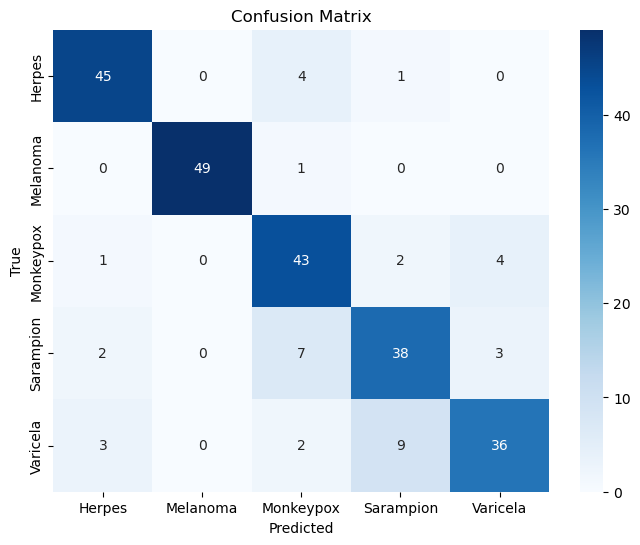

Precision of the MLP :	0.8467896416828665
Recall of the MLP    :	0.844
F1 Score of the Model :	0.8437839929907975
Accuracy: 84.4%


In [88]:
# Calculate Validation Accuracy, Matrix, and Metrics with SGD optimizer
confusion_matrix_and_metrics(alexnet_SGD, val_dataloader, device)
calculate_accuracy(alexnet_SGD, val_dataloader, device)

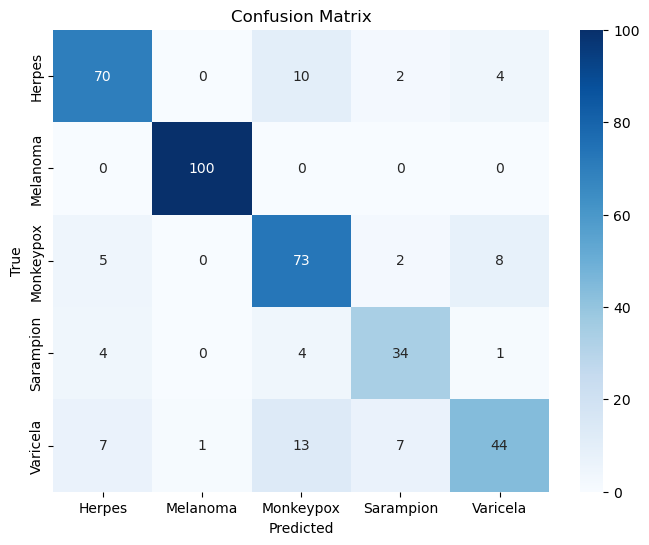

Precision of the MLP :	0.8123075756780084
Recall of the MLP    :	0.8090615456894528
F1 Score of the Model :	0.8080943848075532
Accuracy: 82.51928020565553%


In [89]:
# Calculate Test Accuracy, Matrix, and Metrics with SGD optimizer
confusion_matrix_and_metrics(alexnet_SGD, test_dataloader, device)
calculate_accuracy(alexnet_SGD, test_dataloader, device)

In [103]:
# Declare another Alex Net Model to use Adam optimizer
alexnet_Adam = torchvision.models.alexnet(pretrained=True)
alexnet_Adam.eval()

# Update classifiers of model
alexnet_Adam.classifier[4] = nn.Linear(4096,1024) # update second classifier of model to reduce number of nodes in dense layers of network
alexnet_Adam.classifier[6] = nn.Linear(1024,5) # update output layer of network to have 5 class labels
alexnet_Adam.eval()

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [104]:
alexnet_Adam = alexnet_Adam.to(device)

In [105]:
epochs = 20
learning_rate = 0.00001

criterion = nn.CrossEntropyLoss()
alexnet_optimizer_Adam = torch.optim.Adam(alexnet_Adam.parameters(), lr = learning_rate)
train_model_with_acc(alexnet_Adam, criterion, alexnet_optimizer_Adam, epochs) # Test with Adam optimizer

Epoch: 1, 1.0139968407650788
Accuracy: 74.8%
Epoch: 2, 0.4604525715112686
Accuracy: 82.4%
Epoch: 3, 0.28502305193493765
Accuracy: 82.8%
Epoch: 4, 0.1864725675744315
Accuracy: 84.0%
Epoch: 5, 0.12546077355121574
Accuracy: 83.6%
Epoch: 6, 0.07468118999774258
Accuracy: 84.0%
Epoch: 7, 0.048633481143042445
Accuracy: 81.6%
Epoch: 8, 0.03830008135021975
Accuracy: 84.4%


KeyboardInterrupt: 

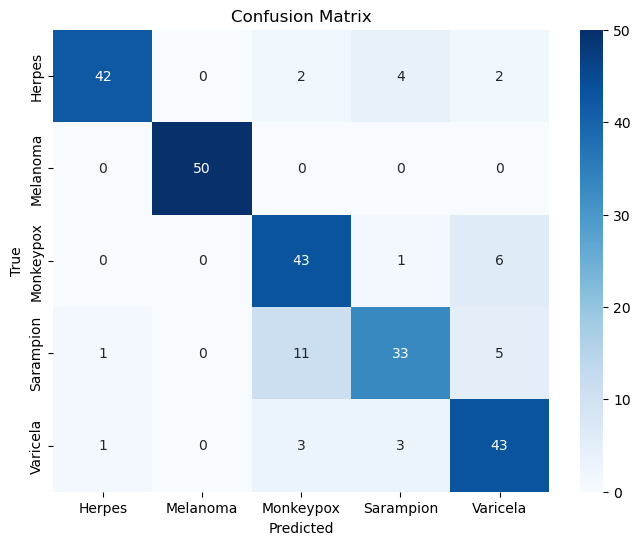

Precision of the MLP :	0.851218841101024
Recall of the MLP    :	0.844
F1 Score of the Model :	0.843840665391275
Accuracy: 84.4%


In [106]:
# Calculate Validation Accuracy, Matrix, and Metrics with Adam optimizer
confusion_matrix_and_metrics(alexnet_Adam, val_dataloader, device)
calculate_accuracy(alexnet_Adam, val_dataloader, device)

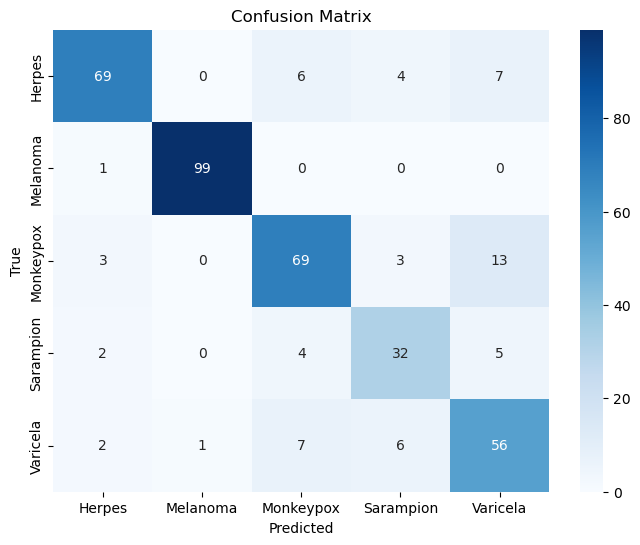

Precision of the MLP :	0.8181797226603429
Recall of the MLP    :	0.8196760629551327
F1 Score of the Model :	0.817805617242121
Accuracy: 83.54755784061696%


In [107]:
# Calculate Test Accuracy, Matrix, and Metrics with SGD optimizer
confusion_matrix_and_metrics(alexnet_Adam, test_dataloader, device)
calculate_accuracy(alexnet_Adam, test_dataloader, device)

In [20]:
# Data organization for Vision Transformers (ViT) Base Model
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Loads each subset directory from your "dataset" folder
train_dataset = datasets.ImageFolder(root='dataset/Train', transform=transform)
test_dataset = datasets.ImageFolder(root='dataset/Test', transform=transform)
val_dataset = datasets.ImageFolder(root='dataset/Val', transform=transform)

# Hyper Parameters for dataset organization and processing
batch_size = 25
num_workers = 3

# Dataloader for each subset which will batch, shuffle, and parallel load the data
train_dataloader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
test_dataloader = data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
val_dataloader = data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

In [27]:
# Declare Vision Transformers (ViT) Base Model
# Load pre-trained Vision Transformer (ViT)
vit_b = models.vit_b_16(weights="IMAGENET1K_V1")

# ViT classification head modified to output 5 classes
vit_b.heads.head = nn.Linear(vit_b.heads.head.in_features, 5, bias=True)

vit_b = vit_b.to(device)

vit_b.eval()

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [28]:
epochs = 50
learning_rate = 0.0001

In [29]:
criterion = nn.CrossEntropyLoss()
vit_optimizer = torch.optim.SGD(vit_b.parameters(), lr=learning_rate, weight_decay=0.005, momentum=0.9)

In [30]:
train_model_with_acc(vit_b, criterion, vit_optimizer, epochs)

Epoch: 1, 1.447945153961579
Accuracy: 50.4%
Epoch: 2, 1.0708593676487606
Accuracy: 65.2%
Epoch: 3, 0.8836081686119238
Accuracy: 68.8%
Epoch: 4, 0.7519909503559271
Accuracy: 73.2%
Epoch: 5, 0.6532853469252586
Accuracy: 77.2%
Epoch: 6, 0.5816205268104871
Accuracy: 81.2%
Epoch: 7, 0.5111924298107624
Accuracy: 83.2%
Epoch: 8, 0.4575989705820878
Accuracy: 84.0%
Epoch: 9, 0.4148354511708021
Accuracy: 85.2%
Epoch: 10, 0.37864755901197594
Accuracy: 85.2%
Epoch: 11, 0.34525808598846197
Accuracy: 85.6%
Epoch: 12, 0.3166782281671961
Accuracy: 86.4%
Epoch: 13, 0.2907853997312486
Accuracy: 86.8%
Epoch: 14, 0.2680689549694459
Accuracy: 87.6%
Epoch: 15, 0.24851574453835687
Accuracy: 88.0%
Epoch: 16, 0.2299246865635117
Accuracy: 88.0%
Epoch: 17, 0.21355299993107715
Accuracy: 88.4%
Epoch: 18, 0.19624538246231774
Accuracy: 88.8%
Epoch: 19, 0.1823415830731392
Accuracy: 88.4%
Epoch: 20, 0.1750093645726641
Accuracy: 89.2%
Epoch: 21, 0.15860823153828582
Accuracy: 90.0%
Epoch: 22, 0.14763772891213497
Accurac

KeyboardInterrupt: 

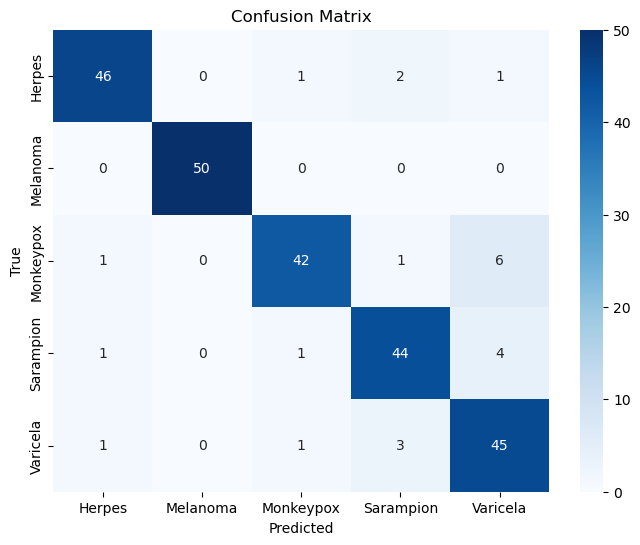

Precision of the MLP :	0.9111360544217687
Recall of the MLP    :	0.908
F1 Score of the Model :	0.9085120118764607
Accuracy: 90.8%


In [31]:
# Caculate Validation Accuracy, Matrix, and Metrics
confusion_matrix_and_metrics(vit_b, val_dataloader, device)
calculate_accuracy(vit_b, val_dataloader, device)

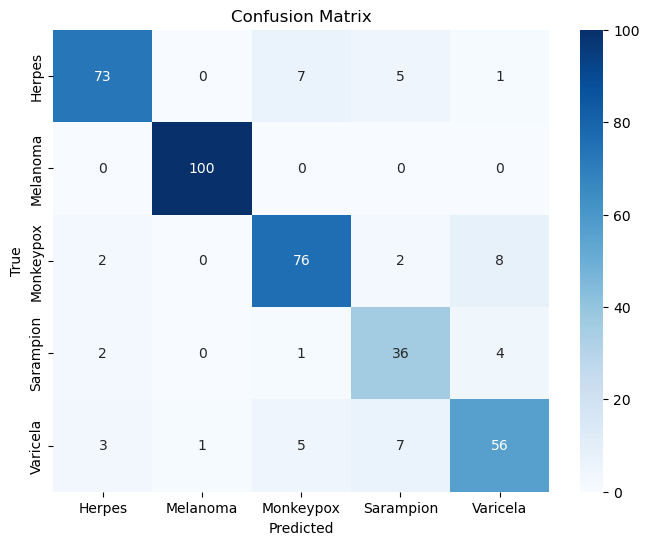

Precision of the MLP :	0.8576251594138407
Recall of the MLP    :	0.8654921306084097
F1 Score of the Model :	0.8603639599159576
Accuracy: 87.66066838046272%


In [32]:
# Caculate Test Accuracy, Matrix, and Metrics
confusion_matrix_and_metrics(vit_b, test_dataloader, device)
calculate_accuracy(vit_b, test_dataloader, device)

In [37]:
# Declare Data Efficient Image Transformer (DeiT)
import timm

deit = timm.create_model("deit_base_patch16_224", pretrained=True)
deit.head = nn.Linear(deit.head.in_features, 5, bias=True)
deit = deit.to(device)

In [40]:
epochs = 50
learning_rate = 0.0001

criterion = nn.CrossEntropyLoss()
deit_optimizer = torch.optim.Adam(deit.parameters(), lr=learning_rate)

In [41]:
train_model_with_acc(deit, criterion, deit_optimizer, epochs)

Epoch: 1, 0.5389888461989661
Accuracy: 89.2%
Epoch: 2, 0.14110116148367524
Accuracy: 88.0%
Epoch: 3, 0.08201508724596351
Accuracy: 91.6%
Epoch: 4, 0.046491516715226076
Accuracy: 92.4%
Epoch: 5, 0.021896045208753396
Accuracy: 91.6%
Epoch: 6, 0.017190357415529434
Accuracy: 89.6%
Epoch: 7, 0.011179832374182297
Accuracy: 90.4%
Epoch: 8, 0.014567497981867442
Accuracy: 89.6%
Epoch: 9, 0.01942693383898586
Accuracy: 90.0%


KeyboardInterrupt: 

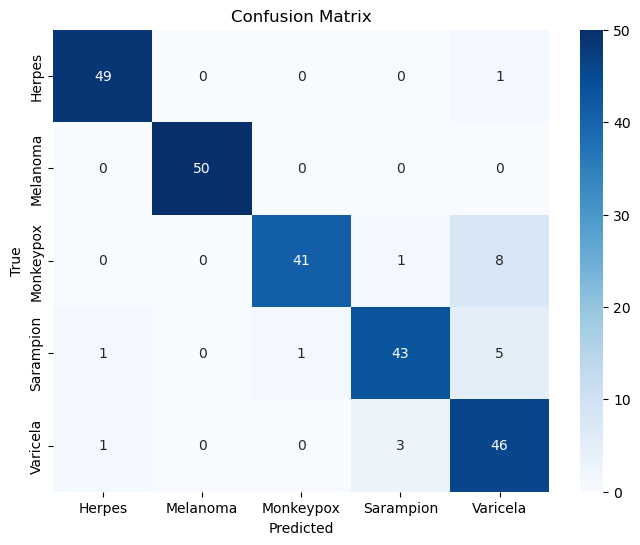

Precision of the MLP :	0.923707014720782
Recall of the MLP    :	0.916
F1 Score of the Model :	0.9169125904074047
Accuracy: 91.6%


In [43]:
# Caculate Validation Accuracy, Matrix, and Metrics
confusion_matrix_and_metrics(deit, val_dataloader, device)
calculate_accuracy(deit, val_dataloader, device)

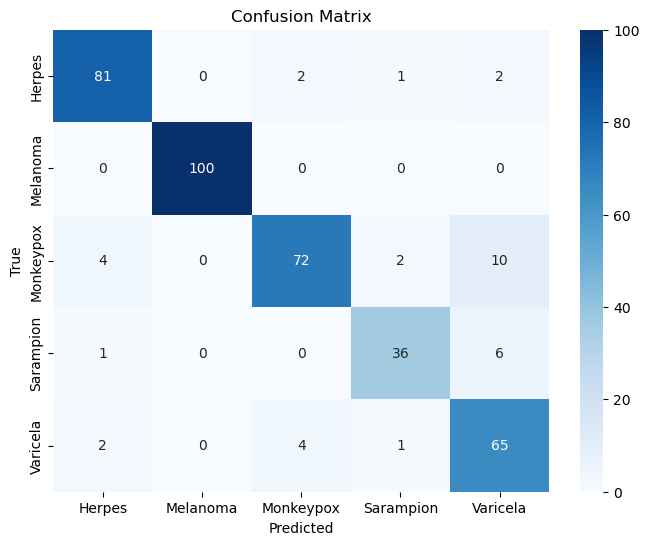

Precision of the MLP :	0.9053327997303899
Recall of the MLP    :	0.9000058726802914
F1 Score of the Model :	0.9009367838428239
Accuracy: 91.00257069408741%


In [44]:
confusion_matrix_and_metrics(deit, test_dataloader, device)
calculate_accuracy(deit, test_dataloader, device)